<Axes: xlabel='DATETIMEDATA'>

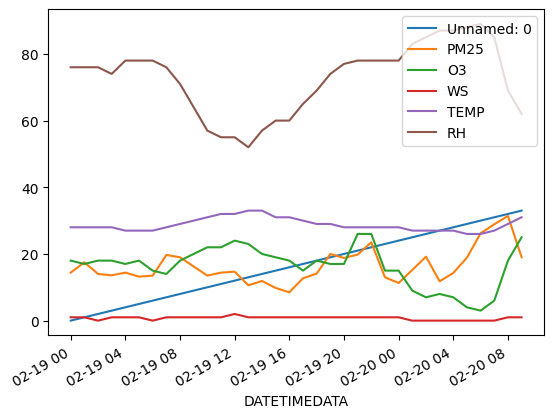

In [5]:
import pandas as pd
data = pd.read_csv('Clean_data.csv')
data["DATETIMEDATA"] = pd.to_datetime(data["DATETIMEDATA"])
data.set_index('DATETIMEDATA', inplace=True)
data.head()
data.plot()

In [12]:
data['MA12'] = data['PM25'].rolling(12).mean()

import plotly.express as px
fig = px.line(data.reset_index(), x='DATETIMEDATA', y=['PM25', 'MA12'], template='plotly_dark')
fig.show()
print(data.head())


                     Unnamed: 0  PM25    O3  WS  TEMP  RH   WD  MA12
DATETIMEDATA                                                        
2024-02-19 00:00:00           0  14.4  18.0   1    28  76  108   NaN
2024-02-19 01:00:00           1  17.5  17.0   1    28  76  106   NaN
2024-02-19 02:00:00           2  14.0  18.0   0    28  76  104   NaN
2024-02-19 03:00:00           3  13.6  18.0   1    28  74   96   NaN
2024-02-19 04:00:00           4  14.4  17.0   1    27  78   94   NaN


In [16]:
train = data[data.index < '2024-02-20 00:00:00']
test = data[data.index >= '2024-02-20 00:00:00']


In [8]:

from pycaret.regression import *
s = setup(data = train, test_data = test, target = 'PM25',  fold = 3, transform_target = True, session_id = 123)


NameError: name 'train' is not defined

In [13]:
from pycaret.regression import *
clf = setup(data, target = 'PM25')

,Description,Value
0,Session id,1113
1,Target,PM25
2,Target type,Regression
3,Original data shape,"(33, 8)"
4,Transformed data shape,"(33, 8)"
5,Transformed train set shape,"(23, 8)"
6,Transformed test set shape,"(10, 8)"
7,Numeric features,7
8,Rows with missing values,33.3%
9,Preprocess,True


In [15]:
best_model = compare_models()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,2.5943,9.0777,2.8006,-0.9074,0.1757,0.1804,0.0060
et,Extra Trees Regressor,2.3602,7.5887,2.6774,-1.2042,0.1595,0.1528,0.0150
omp,Orthogonal Matching Pursuit,2.6840,10.0575,2.9868,-1.6357,0.1798,0.1813,0.0050
llar,Lasso Least Angle Regression,2.6486,10.0438,2.9378,-1.8051,0.1768,0.1771,0.0040
lasso,Lasso Regression,2.6488,10.0444,2.9381,-1.8052,0.1768,0.1771,0.1440
en,Elastic Net,2.6384,10.0330,2.9308,-1.8249,0.1773,0.1769,0.0050
rf,Random Forest Regressor,2.5637,9.2446,2.9527,-1.8357,0.1831,0.1731,0.0160
br,Bayesian Ridge,2.8323,10.6944,3.1274,-1.8812,0.1909,0.1943,0.0040
dummy,Dummy Regressor,3.0472,13.5691,3.5696,-1.9824,0.2238,0.2172,0.0040
lightgbm,Light Gradient Boosting Machine,3.0472,13.5691,3.5696,-1.9824,0.2238,0.2172,0.0070


In [17]:
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.2248,2.0525,1.4327,0.9036,0.0867,0.0859
1,3.4152,17.2758,4.1564,0.1549,0.2140,0.1882
2,3.6115,14.1768,3.7652,-0.9083,0.2117,0.2024
3,2.5086,10.6948,3.2703,-0.2289,0.1762,0.1297
4,2.1217,4.5036,2.1222,0.0695,0.1312,0.1297
5,10.5053,118.5002,10.8858,-25.8708,0.9177,0.6137
6,4.3524,22.0299,4.6936,-33.4218,0.2802,0.3158
7,1.9807,4.2226,2.0549,0.7151,0.1362,0.1454
8,4.5800,27.4843,5.2425,-10.4399,0.3350,0.3860


In [18]:
tuned_lr = tune_model(lr)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7107,0.5192,0.7205,0.9756,0.0497,0.0531
1,3.5229,17.4165,4.1733,0.1480,0.2136,0.1931
2,3.7322,14.9333,3.8644,-1.0102,0.2180,0.2102
3,2.4746,11.7777,3.4319,-0.3534,0.1858,0.1247
4,1.8582,3.5248,1.8774,0.2717,0.1113,0.1118
5,8.0375,67.5483,8.2188,-14.3171,0.5997,0.4730
6,2.6320,7.5576,2.7491,-10.8088,0.1755,0.1922
7,2.2677,5.6864,2.3846,0.6164,0.1565,0.1639
8,4.8768,28.4251,5.3315,-10.8315,0.3398,0.4056


Fitting 10 folds for each of 2 candidates, totalling 20 fits


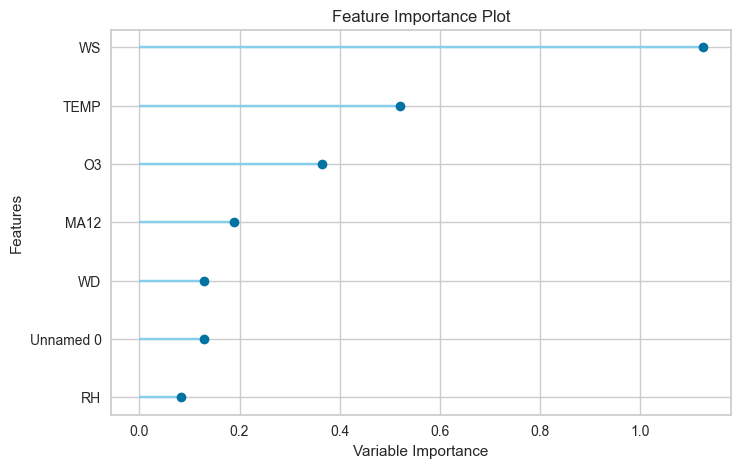

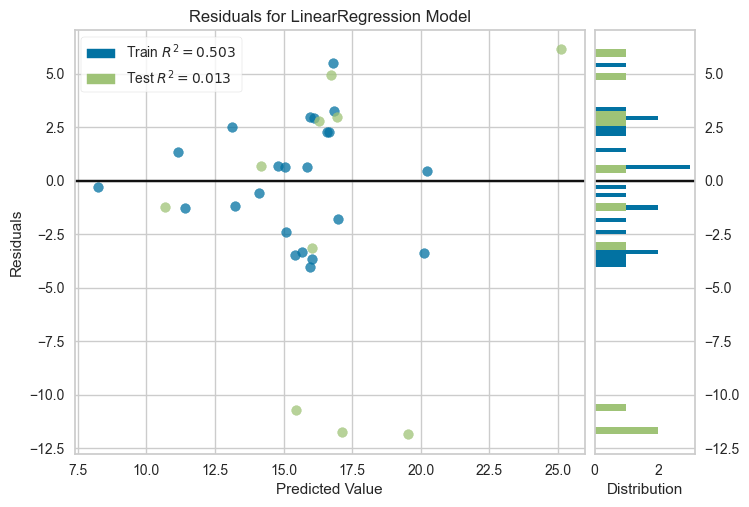

In [20]:
plot_model(tuned_lr, plot='feature')
plot_model(tuned_lr, plot='residuals')

In [23]:
prediction_data = data.drop('PM25', axis=1).copy()
predictions = predict_model(tuned_lr, data=prediction_data)
print(predictions.columns)
print(predictions[['prediction_label']])

Index(['Unnamed: 0', 'O3', 'WS', 'TEMP', 'RH', 'WD', 'MA12',
       'prediction_label'],
      dtype='object')
                     prediction_label
DATETIMEDATA                         
2024-02-19 00:00:00         15.055487
2024-02-19 01:00:00         15.078793
2024-02-19 02:00:00         16.957526
2024-02-19 03:00:00         16.833464
2024-02-19 04:00:00         16.667894
2024-02-19 05:00:00         16.124510
2024-02-19 06:00:00         16.283319
2024-02-19 07:00:00         16.054637
2024-02-19 08:00:00         15.675207
2024-02-19 10:00:00         14.162352
2024-02-19 11:00:00         13.219139
2024-02-19 12:00:00         14.101662
2024-02-19 13:00:00         13.127090
2024-02-19 14:00:00         10.670140
2024-02-19 15:00:00         11.132382
2024-02-19 16:00:00          8.221655
2024-02-19 17:00:00         11.402229
2024-02-19 18:00:00         14.786567
2024-02-19 19:00:00         15.975026
2024-02-19 20:00:00         16.985454
2024-02-19 21:00:00         20.236730
2024-02-19 22:0

In [37]:
predictions = predict_model(tuned_lr, data=prediction_data)
print(predictions)


                     Unnamed: 0    O3  WS  TEMP  RH   WD       MA12  \
DATETIMEDATA                                                          
2024-02-19 00:00:00           0  18.0   1    28  76  108        NaN   
2024-02-19 01:00:00           1  17.0   1    28  76  106        NaN   
2024-02-19 02:00:00           2  18.0   0    28  76  104        NaN   
2024-02-19 03:00:00           3  18.0   1    28  74   96        NaN   
2024-02-19 04:00:00           4  17.0   1    27  78   94        NaN   
2024-02-19 05:00:00           5  18.0   1    27  78  102        NaN   
2024-02-19 06:00:00           6  15.0   0    27  78  102        NaN   
2024-02-19 07:00:00           7  14.0   1    28  76   96        NaN   
2024-02-19 08:00:00           8  18.0   1    29  71  112        NaN   
2024-02-19 10:00:00          10  22.0   1    31  57  136        NaN   
2024-02-19 11:00:00          11  22.0   1    32  55  147        NaN   
2024-02-19 12:00:00          12  24.0   2    32  55  139  15.158334   
2024-0

,Description,Value
0,Session id,123
1,Target,PM25
2,Target type,Regression
3,Original data shape,"(33, 7)"
4,Transformed data shape,"(33, 49)"
5,Transformed train set shape,"(23, 49)"
6,Transformed test set shape,"(10, 49)"
7,Numeric features,4
8,Categorical features,2
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,3.1469,20.8586,3.9488,-0.7315,0.2229,0.1873,0.0430
huber,Huber Regressor,3.3600,21.9490,3.8584,-0.7465,0.2218,0.2070,0.0270
en,Elastic Net,3.3387,22.5145,3.8349,-0.8020,0.2208,0.2103,0.0190
lasso,Lasso Regression,3.3918,22.7851,3.8759,-0.8600,0.2230,0.2145,0.0210
llar,Lasso Least Angle Regression,3.3918,22.7851,3.8759,-0.8600,0.2230,0.2145,0.0200
rf,Random Forest Regressor,3.3030,23.0807,3.9713,-0.8796,0.2280,0.1994,0.0480
dummy,Dummy Regressor,3.4476,23.0439,3.9506,-1.2158,0.2271,0.2216,0.0190
br,Bayesian Ridge,3.5568,23.9880,4.0220,-1.2467,0.2316,0.2283,0.0200
ridge,Ridge Regression,3.6628,25.6119,4.2024,-1.2525,0.2393,0.2292,0.0210
omp,Orthogonal Matching Pursuit,3.8246,29.3866,4.5646,-1.3186,0.2657,0.2398,0.0180


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- DATETIMEDATA_2024-02-19 05:00:00
- DATETIMEDATA_2024-02-19 07:00:00
- DATETIMEDATA_2024-02-19 08:00:00
- DATETIMEDATA_2024-02-19 13:00:00
- DATETIMEDATA_2024-02-19 14:00:00
- ...


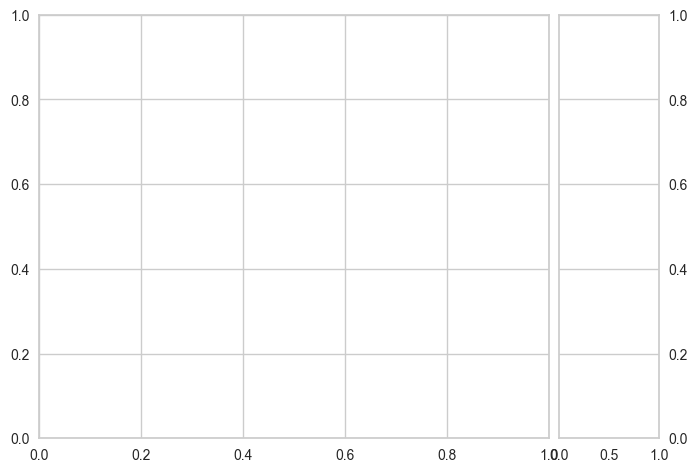

In [21]:

import pandas as pd
from pycaret.regression import *
data = pd.read_csv("Clean_data.csv", index_col="Unnamed: 0")
pm25 = data["PM25"]
features = data.drop("PM25", axis=1)
data_prepared = setup(data=features, target=pm25, session_id=123)
best_model = compare_models()
final_model = finalize_model(best_model)
future_features = features.copy()
future_features["DATETIMEDATA"] = pd.date_range(start=data["DATETIMEDATA"].max(), periods=33, freq="H")
predictions = predict_model(final_model, data=future_features)
print(predictions)


,Description,Value
0,Session id,123
1,Target,PM25
2,Target type,Regression
3,Original data shape,"(33, 7)"
4,Transformed data shape,"(33, 49)"
5,Transformed train set shape,"(23, 49)"
6,Transformed test set shape,"(10, 49)"
7,Numeric features,4
8,Categorical features,2
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,3.1469,20.8586,3.9488,-0.7315,0.2229,0.1873,0.0470
huber,Huber Regressor,3.3600,21.9490,3.8584,-0.7465,0.2218,0.2070,0.0240
en,Elastic Net,3.3387,22.5145,3.8349,-0.8020,0.2208,0.2103,0.0190
lasso,Lasso Regression,3.3918,22.7851,3.8759,-0.8600,0.2230,0.2145,0.0190
llar,Lasso Least Angle Regression,3.3918,22.7851,3.8759,-0.8600,0.2230,0.2145,0.0210
rf,Random Forest Regressor,3.3030,23.0807,3.9713,-0.8796,0.2280,0.1994,0.0490
dummy,Dummy Regressor,3.4476,23.0439,3.9506,-1.2158,0.2271,0.2216,0.0200
br,Bayesian Ridge,3.5568,23.9880,4.0220,-1.2467,0.2316,0.2283,0.0200
ridge,Ridge Regression,3.6628,25.6119,4.2024,-1.2525,0.2393,0.2292,0.0210
omp,Orthogonal Matching Pursuit,3.8246,29.3866,4.5646,-1.3186,0.2657,0.2398,0.0190


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- DATETIMEDATA_2024-02-19 05:00:00
- DATETIMEDATA_2024-02-19 07:00:00
- DATETIMEDATA_2024-02-19 08:00:00
- DATETIMEDATA_2024-02-19 13:00:00
- DATETIMEDATA_2024-02-19 14:00:00
- ...


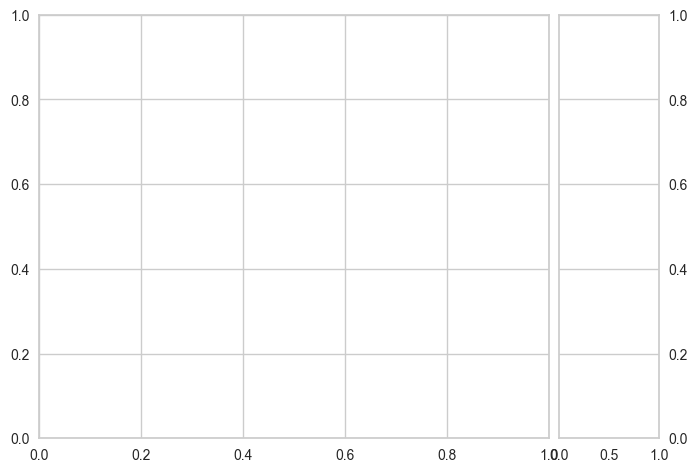

In [22]:
import pandas as pd
from pycaret.regression import *

# Assuming your data is in a CSV file named "Clean_data.csv"
data = pd.read_csv("Clean_data.csv", index_col="Unnamed: 0")

# Extract PM2.5 column
pm25 = data["PM25"]

# Extract features (all columns except PM2.5)
features = data.drop("PM25", axis=1)

# Prepare data for PyCaret
data_prepared = setup(data=features, target=pm25, session_id=123)

# Compare models and select the best one
best_model = compare_models()

# Finalize the chosen model
final_model = finalize_model(best_model)

# Create data for future predictions
future_features = features.copy()

# Generate timestamps for the next 33 hours
future_features["DATETIMEDATA"] = pd.date_range(start=data["DATETIMEDATA"].max(), periods=33, freq="H")

# Predict PM2.5 values for the future timestamps
predictions = predict_model(final_model, data=future_features)

# Plot model residuals (assuming you want to see the residuals)
plot_model(final_model, plot="residuals")

# Print the predicted PM2.5 values
print(predictions)
